In [17]:
import pygal
from IPython.display import SVG, display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium

In [18]:
df = pd.read_csv("data/events_prepared.csv")
df.head()

,Unnamed: 0,web-scraper-order,name,description,price,address,category,date_formatted,time_from,time_until,...,description_len,lat,lon,bfs_nummer,gemeinde,distance_bahnhof,kanton,absolute_young_pop,relative_young_pop,pop_dens
0,0,1701178304-1235,Live-Musik mit Sina Anastasia,ihr name *ein hauch von melodie* ihre ausstra...,NaN,"Baselstrasse 43, Riehen",Konzert / Singer & Songwriter,2023/12/01,19:00:00,22:00:00,...,2860.0,47.584694,7.649675,2703,Riehen,231.871315,BS,3679.0,16.8,1922.3
1,1,1701178306-1236,"Metal Marmot, 1. - 2. Dezember 2023",metal marmot im dezember 2023: freitag 1. deze...,40.0,"Kanderstegstrasse 25, Frutigen",Konzert / Hard Rock & Heavy Metal,2023/12/01,19:00:00,NaN,...,245.0,46.586052,7.647597,563,Frutigen,431.905393,BE,1621.0,23.1,95.4
2,2,1701178308-1237,JAMfreeday,alle sind herzlich eingeladen um zu musizieren...,NaN,"28, Herisau",Konzert,2023/12/01,19:00:00,NaN,...,188.0,47.387520,9.309265,3001,Herisau,1931.580777,AR,4094.0,26.0,624.2
3,3,1701178310-1238,Am Hummelwald,"der kurzprosaband ""am hummelwald - miniaturen ...",NaN,"St.Leonhard-Strasse 40, St.Gallen",Konzert,2023/12/01,19:00:00,NaN,...,1060.0,47.422333,9.370071,3203,St. Gallen,94.997717,SG,25343.0,32.9,1916.7
4,4,1701178312-1239,BELPHEGOR 30 Year Tour Special Guest: Arkona &...,belphegor marschiert durch europa winter mmxxi...,38.0,"Aarburg, CH",Konzert / Hard Rock & Heavy Metal,2023/12/01,19:00:00,23:50:00,...,734.0,47.324833,7.905110,4271,Aarburg,559.350472,AG,2691.0,30.8,1781.0


# Non-graphical EDA

## Shape all events (number of rows and columns)

In [19]:
df.shape

(1543, 22)

## Shape of data that has no missing value (so it has a price and duration)

In [20]:
df_price = df.dropna()
df_price.shape

(374, 22)

## Summary statistics of numeric variables

In [21]:
df_price.describe()

,Unnamed: 0,price,duration_seconds,description_len,lat,lon,bfs_nummer,distance_bahnhof,absolute_young_pop,relative_young_pop,pop_dens
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,789.173797,24.544652,17832.513369,1435.117647,47.292046,8.326886,1980.700535,730.037361,44922.248663,29.815775,2716.490107
std,471.518674,14.889475,8152.534276,1589.782323,0.240267,0.634285,1577.139616,742.207398,58710.869170,4.541379,2242.757484
min,4.000000,0.000000,3600.000000,18.000000,46.295605,6.647134,2.000000,25.709271,148.000000,16.800000,10.600000
25%,396.750000,15.000000,10800.000000,513.750000,47.143669,7.714313,261.000000,345.019350,2912.000000,26.600000,840.200000
50%,769.000000,24.975000,18000.000000,833.500000,47.375475,8.451987,1953.500000,531.288302,7409.500000,30.400000,1781.000000
75%,1207.750000,30.000000,23400.000000,1374.000000,47.444996,8.556387,3276.000000,862.605955,52836.000000,33.600000,4580.500000
max,1533.000000,130.000000,43200.000000,13991.000000,47.697395,10.275710,6297.000000,6023.316921,150915.000000,36.300000,7170.500000


## Skewness

In [22]:
df_price[['price', 'duration_seconds', 'description_len', 'distance_bahnhof', 'relative_young_pop', 'pop_dens']].skew()

price                 2.223245
duration_seconds      0.170403
description_len       2.683530
distance_bahnhof      3.717600
relative_young_pop   -0.535015
pop_dens              0.699682
dtype: float64

## Kurtosis

In [23]:
df_price[['price', 'duration_seconds', 'description_len', 'distance_bahnhof', 'relative_young_pop', 'pop_dens']].kurtosis()

price                 10.809757
duration_seconds      -0.496729
description_len       12.466897
distance_bahnhof      19.660409
relative_young_pop    -0.418454
pop_dens              -0.710574
dtype: float64

## Cross-tabulation
Shows the relation between if an event is a concert or party and it's price

In [24]:
pd.crosstab(df_price['is_concert'], df['price'])

price,0.0,5.0,8.0,9.0,10.0,12.0,12.9,13.0,15.0,16.0,...,50.0,53.0,58.0,59.0,60.0,68.0,85.0,99.0,110.0,130.0
is_concert,,,,,,,,,,,,,,,,,,,,,
False,0,7,7,1,31,3,2,1,26,1,...,0,0,0,4,0,1,0,1,0,1
True,11,0,1,0,4,0,0,4,14,0,...,6,1,1,1,1,0,1,0,1,0


## Correlation matrix

In [25]:
corr = df_price[['price', 
          'duration_seconds', 
          'description_len', 
          'distance_bahnhof',
          'relative_young_pop',
          'pop_dens']].cov().corr()
corr

,price,duration_seconds,description_len,distance_bahnhof,relative_young_pop,pop_dens
price,1.000000,-0.924486,0.352042,-0.057109,-0.474793,-0.406547
duration_seconds,-0.924486,1.000000,-0.076907,0.107167,0.273257,0.155626
description_len,0.352042,-0.076907,1.000000,-0.307569,0.035870,-0.052828
distance_bahnhof,-0.057109,0.107167,-0.307569,1.000000,-0.643079,-0.553863
relative_young_pop,-0.474793,0.273257,0.035870,-0.643079,1.000000,0.979789
pop_dens,-0.406547,0.155626,-0.052828,-0.553863,0.979789,1.000000


# Graphical EDA

## Boxplot for the price

<AxesSubplot:xlabel='price'>

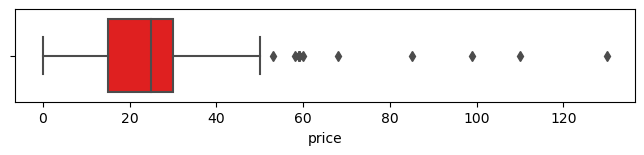

In [26]:
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_price['price'], color="red")

## Scatterplot

TypeError: 'str' object is not callable

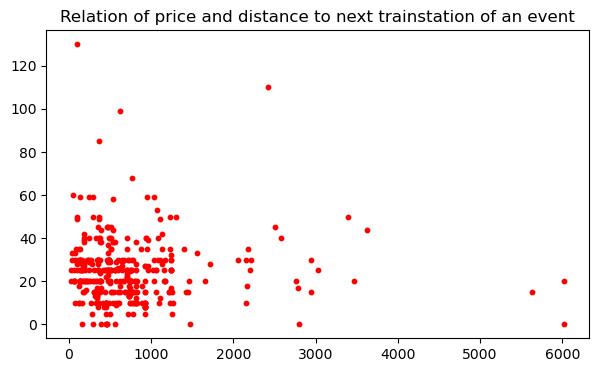

In [28]:
plt.figure(figsize=(7,4))
plt.scatter(df_price['distance_bahnhof'], 
           df_price['price'], 
           color="red", 
           alpha=1.0,
           s=10)
plt.title('Relation of price and distance to next trainstation of an event', fontsize=12)
plt.xlabel('Distance to the next train station in meters')
plt.ylabel('Price in CHF')
plt.show()

# Visualization of geographical data

## Map of all events

In [29]:
# Initialisierung der Map
m = folium.Map(location=[46.8, 8.1], zoom_start=8)

for i in range(0, len(df_price)):
    folium.Marker(location=(df.iloc[i]['lat'], 
                            df.iloc[i]['lon']), 
                  popup=df.iloc[i]['address']).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

# Plot map
m

## Distribution of events by cantons

In [30]:
kanton_count = df["kanton"].value_counts().to_dict()
kanton_count_map = {}
for k, v in kanton_count.items():
    kanton_count_map["kt-" + k.lower()] = v # The switzerland map needs the cantons in the format 'kt-..' for example 'kt-zh'

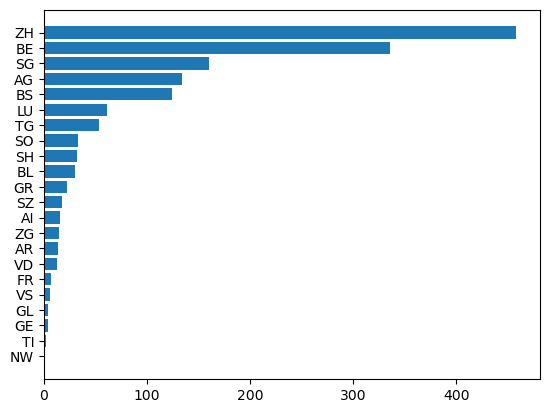

In [31]:
df_count = pd.DataFrame.from_dict(kanton_count, orient="index")
df_count.reset_index(inplace=True)
df_count = df_count.rename(columns = {'index':'kanton', 0: 'count'})
df_count = df_count.sort_values('count', ascending=True)

plt.barh(df_count['kanton'], df_count['count'])
plt.show()

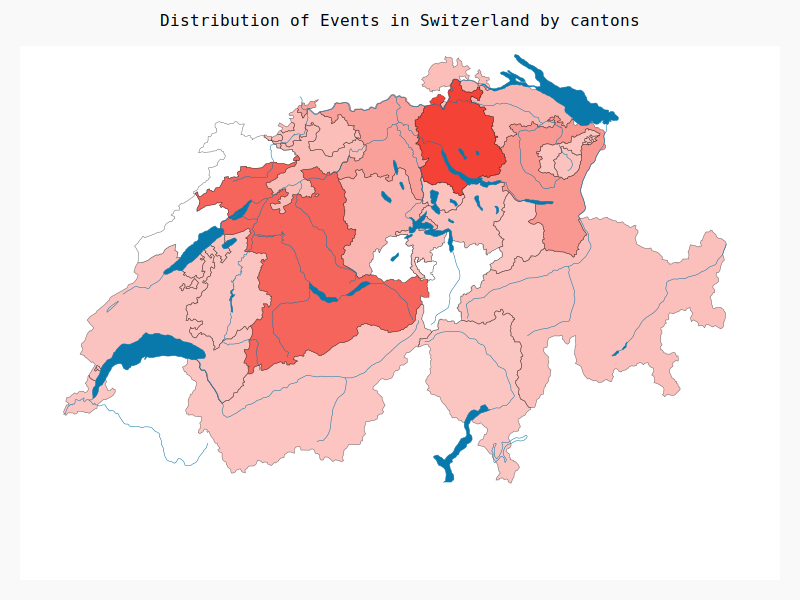

In [33]:
ch_chart = pygal.maps.ch.Cantons(show_legend=False)
ch_chart.title = 'Distribution of Events in Switzerland by cantons'

ch_chart.add('Random Data', kanton_count_map) 


display(SVG(ch_chart.render(disable_xml_declaration=True)))

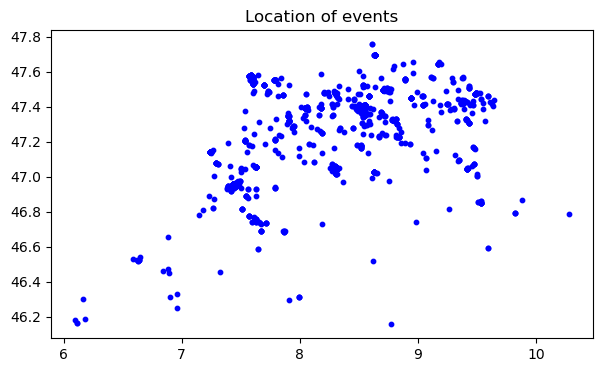

In [34]:
plt.figure(figsize=(7,4))
plt.scatter(df['lon'], 
           df['lat'], 
           color="Blue", 
           alpha=1.0,
           s=10)
plt.title('Location of events', fontsize=12)
plt.show()

### Jupyter notebook --footer info--

In [94]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Darwin | 23.1.0
Datetime: 2023-12-02 23:28:40
Python Version: 3.9.13
-----------------------------------
